In [1]:
#Importamos las librerias utiles
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

## Ejercicio 1: Red de unidades de umbral lineal

Programa y evalua una red de neuronas con funciones de activacion escalon unitario que aproxime la operacion XNOR dada por:


| $x_1$ | $x_2$ | $y$ |
| :- | :- | :- |
| 0 | 0 | 1 
| 0 | 1 | 0
| 1 | 0 | 0
| 1 | 1 | 1

La función de activación escalon está dada por 

$\phi=   \left\{
\begin{array}{ll}
      1 & x> 0 \\
      0 & otro caso \\
\end{array} 
\right.$

In [2]:
#creamos una funcion en python para representar la funcion de activacion
#escalon
def escalon(z):
    if z > 0.0:
        return 1.0
    else:
        return 0.0

La operación llevada acabo por la neurona artificial es una suma pesada evaluada en la funcion de activación $\phi$. La suma pesada consiste en multiplicar cada entrada por su correspondiente peso y sumar el sesgo, es decir,

$z= w_1 \cdot x_1 + w_2 \cdot x_2 + ... + w_n \cdot x_n + b$

o bien,

$z = W^{T}\vec{x} + b$

Un XNOR puede simplificarse de la siguiente manera:

$$\overline{x_1 \oplus x_2} = (x_1 \land x_2) \lor (\overline{x_1} \land \overline{x_2})$$

Probar que la expresion booleana anterior se cumple para los $x_1$ y $x_2$ de la tabla es trivial por lo que se deja al lector.

La expresion booleana deja en evidencia que nuestra red nueronal o perceptron debe contener tres neuronas "internas" que deben cumplir las operaciones de AND, NOR y OR. Debido a esto es necesario vectorizar nuestra funcion de activacion escalon ya que ahora esta funcion comera vectores, esto se hace con la funcion de numpy np.vectorize(function)

In [3]:
#definimos el perceptron multicapa
def perceptronMulticapa(vector_x, W1, b1, W2, b2):
    #realizamos la funcion escalon vectorizado
    escalonVectorizado = np.vectorize(escalon)
    #definimos/obtenemos la salida de la primera capa oculta
    capa1 = escalonVectorizado(np.dot(W1.T , vector_x) + b1)
    #definimos/obtenemos la salida de la ultima capa
    capa2 = escalonVectorizado(np.dot(W2.T, capa1) + b2)
    #regresa el valor de la ultima capa
    return capa2

Probemos con las siguientes matrices de pesos y sesgos para reproducir la compuerta XNOR:

$$W_1 = \begin{pmatrix}
  1 & -1\\ 
  1 & -1
\end{pmatrix}$$  
$$\vec{b_1} = (-1,1)$$
$$W_2 =(2,2)$$
$$b_2 = -1 $$

In [4]:
#definimos el vector de entradas x1 y x2
X = np.array([[0., 0.], [0., 1.], [1., 0.], [1., 1.]])
#definimos las salidas del xnor
y_xnor = np.array([1., 0., 0., 1.])
#definimos la matriz de pesos W1 y el sesgo b1
W1 = np.array([[1, -1], [1, -1]])
b1 = np.array([-1, 1])
#definimos la matriz de pesos W2 y el sesgo b2
W2 = np.array([[2], [2]])
b2 = np.array([-1])
#Imprimimos en forma de tabla todos los valores de x_j, y y la prediccion
print('-----------------------------')
print('x_1 \tx_2 \ty\ty_hat')
print('-----------------------------')
#iteramos sobre todos los valores de X
for i in range(X.shape[0]):
    #realizamos la prediccion haciendo uso del perceptronMulticapa
    y_hat = perceptronMulticapa(X[i], W1, b1, W2, b2)
    print('{0}\t{1}\t{2}\t{3}'.format(X[i, 0], X[i, 1], y_xnor[i], y_hat[0]))

-----------------------------
x_1 	x_2 	y	y_hat
-----------------------------
0.0	0.0	1.0	1.0
0.0	1.0	0.0	0.0
1.0	0.0	0.0	0.0
1.0	1.0	1.0	1.0


Ahora hay que definir la retropropagacion y la funcion de entrenamiento para que el perceptronMulticapa aprenda por si solo unos pesos que modelen la XNOR.
Vamos a definir una red densa con 2 neuronas de entrada y una sola capa oculta con 15 neuronas con funcion de activacion sigmoide y una neurona de salida con la misma funcion de activacion. La funcion sigmoide esta definida como:

$$\sigma (z) = \frac{1}{1+exp(-z)}$$

Cuya derivada es:

$$\frac{d}{dz} \sigma (z) = \sigma (z) (1-\sigma (z))$$

In [5]:
#creamos la funcion sigmoide
def sigmoid(z):
    return 1/(1+np.exp(-z))
#creamos la derivada de la funcion sigmoide
def sigmoidDerivative(w):
    return np.multiply(sigmoid(w), (1-sigmoid(w)))

Dado que la compuerta XNOR recibe dos entradas y escupe dos salidas podemos pensar esta XNOR como un problema de clasificacion binaria. Por esta razon tenemos que usar la funcion de perdida entopia binaria cruzada que se define como:

$$BinaryCrossEntropy(\vec{y},\hat{\vec{y}}) = -\sum^{N}_{i=1} \left(y^{(i)}log\hat{y}^{(i)} + (1-y^{(i)})log(1-\hat{y}^{(i)})  \right)$$

In [6]:
#creamos la funcion de perdida entropia cruzada binaria
def BCrossEnt(y,p):
    p[p == 0] = np.nextafter(0., 1.)
    p[p == 1] = np.nextafter(1., 0.)
    return -(np.log(p[y == 1]).sum() + np.log(1 - p[y == 0]).sum())

Una metrica para medir la calidad de las predicciones se encuentra en la exactitud definida como:

$$Exactitud = \frac{pred correctas}{total de datos}$$

In [7]:
#definimos la funcion de exactitud
def exactitud(y, prediccion):
    return (y == prediccion).mean() * 100

La propagacion hacia adelante depende de la red densa. Como hay una capa oculta y una de salida vamos a tener dos matrices de pesos $W_{1,2}$ y dos sesgos $b_{1,2}$ una para cada una de las capas. Para este caso la propagacion hacia adelante se define como:

$$\vec{a}^{(1)} = \vec{x}^{(i)}$$
$$\vec{z}^{(2)} = W^{(1)T} \cdot \vec{a}^{(1)} + \vec{b}^{(1)}$$
$$\vec{a}^{(2)} = \phi (\vec{z}^{2})$$
$$\vec{z}^{(3)} = W^{(2)T} \cdot \vec{a}^{(2)} + \vec{b}^{(2)}$$
$$\vec{a}^{(3)} = \phi (\vec{z}^{3})$$
$$\hat{y}^{(i)} = a{(3)}$$

donde $\phi$ es la funcion de activacion

In [8]:
#definimos la funcion de propagacion
def propagacion(x, w1, b1, w2, b2):
    #calculamos z2
    z2 = (w1.T @ x[:, np.newaxis]) + b1
    #z2 = np.dot(w1.T,x[:, np.newaxis]) + b1
    #calculamos a2
    a2 = sigmoid(z2)
    #calculamos z3
    #z3 = (w2.T @ a2) + b2
    z3 = np.dot(w2.T, a2) + b2
    #hacemos la prediccion (calculamos a3)
    prediccion = sigmoid(z3)
    #regresamos los valores que acabamos de calcular
    return z2, a2, z3, prediccion

Para entrenar vamos a usar el descenso del gradiente, que deriva la funcion de perdida y propaga hacia atras o retroporpaga con respecto a los pesos y sesgos en cada una de estas capas. El algoritmo de retropropagacion nos dice que: Debemos calcular las derivadas parciales de la perdida con respecto a cada peso y sesgo capa por capa, comenzando por la capa de salida y propogandolas hacia atras para calcular las de la capa anterior.

In [9]:
#definimos la funcion de retropropagacion
def retropropagacion(x, y, learningRate = 0.1, epochs = 50, neuronasOcultas=10):
    ejemplos = x.shape[0]
    entradas = x.shape[1]
    #inicializacion de las matrices W y sesgos b
    W1 = np.sqrt(1.0 / entradas) * np.random.randn(entradas, neuronasOcultas)
    b1 = np.zeros((neuronasOcultas, 1))
    W2 = np.sqrt(1.0 / neuronasOcultas) * np.random.randn(neuronasOcultas, 1)
    b2 = np.zeros((1, 1))
    #definimos el vector de perdidas, que en cada epoca se va a actualizar
    perdidas = np.zeros((epochs))
    #definimos el vector dew exactitudes que en cada epoca se ca a actualizar
    exactitudes = np.zeros((epochs))
    #definimos el vector de predicciones que corresponde al numero de salidas
    predicciones = np.zeros((y.shape))
    #iteramos sobre las epocas
    for epoch in range(epochs):
        #iteramos sobre todos los ejemplos
        for ejemplo in range(ejemplos):
            #calculamos los vectores resultantes de la propagacion
            z2, a2, z3, prediccion = propagacion(x[ejemplo], W1, b1, W2, b2)
            #calculamos el gradiente de la ultima capa
            gradCapa2 = prediccion - y[ejemplo]
            dw2 = np.outer(a2, gradCapa2)
            db2 = gradCapa2
            
            gradCapa1 = (W2 @ gradCapa2) * sigmoidDerivative(z2)
            dw1 = np.outer(x[ejemplo], gradCapa1)
            db1 = gradCapa1
            #actualizamos los pesos de W2 y b2
            W2 = W2 - learningRate * dw2
            b2 = b2 - learningRate * db2
            #actualizamos los pesos de W1 y b1
            W1 = W1 - learningRate * dw1
            b1 = b1 - learningRate * db1
            #asignamos nuestra prediccion
            predicciones[ejemplo] = prediccion
        #calculamos la perdida para la epoca actual
        perdidas[epoch] = BCrossEnt(y,predicciones)
        #calculamos las exactitudes para la epoca actual
        exactitudes[epoch] = exactitud(y, np.round(predicciones))
        #imprimimos la perdida y la exactitud de cada epoca
        print('Epoch {0}: Perdida = {1} Exactitud = {2}'.format(epoch,perdidas[epoch],exactitudes[epoch]))
    return W1, W2, b1, b2, perdidas, exactitudes

In [10]:
#definimos las entradas
x = np.array([[0, 0], [0, 1], [1, 0], [1, 1]])
#definimos las salidas
y = np.array([[1, 0, 0, 1]]).T
#Para reproducibilidad ponemos una semilla
np.random.seed(0)
#entrenamos la red
W1, W2, b1, b2, perdidas, exactitudes = retropropagacion(x,y,epochs=40,learningRate=3,neuronasOcultas=15)

Epoch 0: Perdida = 17.085611744385808 Exactitud = 25.0
Epoch 1: Perdida = 6.627037195905615 Exactitud = 25.0
Epoch 2: Perdida = 5.31649212686404 Exactitud = 50.0
Epoch 3: Perdida = 4.976556258534669 Exactitud = 50.0
Epoch 4: Perdida = 4.90470437924737 Exactitud = 50.0
Epoch 5: Perdida = 4.8491053302920815 Exactitud = 50.0
Epoch 6: Perdida = 4.8030856086173 Exactitud = 50.0
Epoch 7: Perdida = 4.763681529882156 Exactitud = 50.0
Epoch 8: Perdida = 4.728632099071005 Exactitud = 50.0
Epoch 9: Perdida = 4.696334553716616 Exactitud = 50.0
Epoch 10: Perdida = 4.665616213300607 Exactitud = 50.0
Epoch 11: Perdida = 4.635562604085066 Exactitud = 50.0
Epoch 12: Perdida = 4.6054065855152135 Exactitud = 50.0
Epoch 13: Perdida = 4.574458493818899 Exactitud = 50.0
Epoch 14: Perdida = 4.542063016020679 Exactitud = 50.0
Epoch 15: Perdida = 4.507575430346115 Exactitud = 50.0
Epoch 16: Perdida = 4.470354814930175 Exactitud = 50.0
Epoch 17: Perdida = 4.4297750433057175 Exactitud = 50.0
Epoch 18: Perdida = 

Para los hiperparametros encontre que:
* Si el learning rate es muy alto > 20, entonces la exactitud se queda atascado en un solo valor
* Si el learning rate es menor que 1, entonces la perdida disminuye mul lentamente pero la exactitud tiende a incrementar
* Si se ponen muchas neuronas > 25 pero <200 con un learning rate de 1 la exactitud tiende a 75
* Si se ponen mas de 200 neuronas con  un LR de 1 la exactitud tiende a 50
* Con solo tres neuronas son necesarias mas de 252 epocas para que la exactitud supere 75
* Para alcanzar 100 de exactitud los hiperparametros deben setearse en 252 epocas, LR de 1 y 15 neuronas ocultas. Seguramente hay otros hiperparametros que llevan a exactitud 100.

In [11]:
print('Con los hiperparametros de 252 epocas, LR de 1 y 15 neuronas ocultas se encuentra una exactitud de 100')
print('Para dichos hiperparametros tenemos que')
print('Matriz de pesos w1')
print(W1)
print('############################################################')
print('vector de sesgos b1')
print(b1)
print('############################################################')
print('Matriz de pesos w2')
print(W2)
print('############################################################')
print('vector de sesgos b2')
print(b2)
print('############################################################')

Con los hiperparametros de 252 epocas, LR de 1 y 15 neuronas ocultas se encuentra una exactitud de 100
Para dichos hiperparametros tenemos que
Matriz de pesos w1
[[ 0.50662598 -0.74991573  0.31176988  0.45389428  2.99594927 -5.02504671
   0.05827254 -0.85174377 -0.29571625 -6.7581862  -0.02076004  0.20849095
  -0.06246649 -0.75721253 -0.91899227]
 [-1.91680596 -1.0283705  -2.04163752 -1.64943881 -5.34324041 -5.07794316
  -1.77635048 -1.07391032 -2.04017652  3.88369323 -2.31258195 -1.8471883
  -1.85460368 -1.07405084 -0.84756904]]
############################################################
vector de sesgos b1
[[-1.95589077]
 [-1.98314928]
 [-1.65971833]
 [-2.28234129]
 [-1.08815307]
 [ 1.34648911]
 [-1.88841479]
 [-1.70368443]
 [-1.59427575]
 [-1.60473691]
 [-1.45491132]
 [-1.93029549]
 [-1.76541342]
 [-1.88925265]
 [-1.97425662]]
############################################################
Matriz de pesos w2
[[-0.99239874]
 [-0.64194037]
 [-1.02884762]
 [-0.74453693]
 [-4.69301417]
 [

Para comprobar que realmente los valores son correctos podemos hacer las operaciones manualmente. Pero ya tenemos la funcion de propagacion que lo hace y nos regresa la prediccion, entonces

In [12]:
print('-----------------------------')
print('x_1 \tx_2 \ty\ty_hat')
print('-----------------------------')
for i in range(x.shape[0]):
    #calculamos la prediccion usando las W's y las b's con la funcion de propagacion
    #los valores de a2, z2 y z3 no se usan por eso tienen el nombre de foo
    foo1, foo2, foo3, prediccionDespuesdeEntrenar = propagacion(x[i],W1,b1,W2,b2)
    print('{0}\t{1}\t{2}\t{3}'.format(x[i, 0], x[i, 1], y_xnor[i], np.round(prediccionDespuesdeEntrenar[0][0])))

-----------------------------
x_1 	x_2 	y	y_hat
-----------------------------
0	0	1.0	1.0
0	1	0.0	0.0
1	0	0.0	0.0
1	1	1.0	1.0


Ahora Graficamos las perdidas por cada epoca y la exactitud por cada epoca

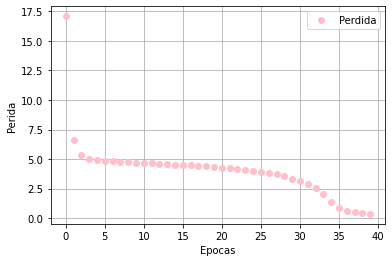

In [13]:
#ploteamos la perdida y la exactitud a traves de las epocas
plt.plot(np.arange(perdidas.size), perdidas, 'o', label='Perdida', color = 'pink')
plt.legend()
plt.xlabel('Epocas')
plt.ylabel('Perida')
plt.grid(True)
plt.show()

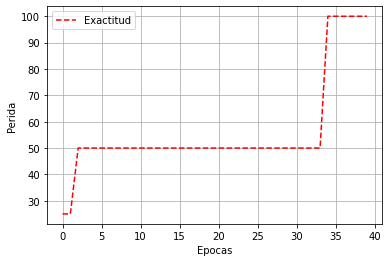

In [14]:
plt.plot(np.arange(exactitudes.size), exactitudes, '--', label='Exactitud', color='red')
plt.legend()
plt.xlabel('Epocas')
plt.ylabel('Perida')
plt.grid(True)
plt.show()